# Executive Summary  

This notebook explores data from the **Commercial Buildings Energy Consumption Survey (CBECS, 2018)** to identify key predictors of **building energy use**, measured as total annual major fuels consumption (`MFBTU`).  

The goals of this analysis are to:  
1. Understand how building characteristics, equipment, and operational factors influence energy use.  
2. Clean and standardize complex survey data containing numerous categorical codes, missing values, and top-coded entries.  
3. Log-transform and model `MFBTU` to mitigate heavy right skew and enable more stable statistical modeling.  
4. Use a **Random Forest Regressor** to screen for feature importance and guide future model development and feature pruning.  

All preprocessing decisions—such as recoding special survey values, handling “Not applicable” responses, and combining redundant variables—were grounded in the official CBECS codebook documentation.

---

## Key Takeaways (so far)

- **Extensive data cleaning was required.** Many variables used coded values (e.g., `994`, `995`, `9995`) to represent ranges or confidentiality flags. These were standardized and flagged with indicator variables. 
- **Missing values were context-specific.** For some questions, “missing” implied *not applicable* (e.g., no elevator in a one-story building), while in others it indicated unknown data. These cases were handled differently to preserve meaning.  
- **Energy use (`MFBTU`) is highly right-skewed.** A log transformation (`LOG_MFBTU`) provides a more balanced target for regression modeling.  
- **Feature pruning and recoding reduced the dataset** from roughly 1,200 to a few hundred meaningful features, while keeping indicators for capped or imputed values.  
- **Next steps** include:  
  - Migrating stable cleaning logic to a reusable pipeline (`02_build_dataset.py`).  
  - Running systematic feature importance and correlation analyses on the cleaned dataset.  
  - Building baseline regression and tree-based models with proper train/test splits for validation.

---

*This notebook focuses on exploratory data analysis (EDA) and feature preparation.  
Subsequent notebooks will formalize model training, validation, and interpretation.*

In [1776]:
# --- imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib, yaml, warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# --- project paths
PROJ = pathlib.Path().resolve().parent
CFG  = yaml.safe_load(open(PROJ / "conf" / "config.yaml"))
RAW_DIR = PROJ / CFG["data"]["raw_dir"]

Data load (2018 only for now since the feature cleaning is so extensive.. will only repeat feature cleaning for relevant 2012 features)

In [1777]:
df = pd.read_csv(RAW_DIR / "cbecs_2018_microdata.csv")
print(df.shape)  # rows, columns
df.head(5)

(6436, 1249)


,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,BLDSHP,GLSSPC,NFLOOR,BASEMNT,FLCEILHT,ATTIC,ELEVTR,NELVTR,ESCLTR,NESLTR,YRCONC,RENOV,RENCOS,RENADD,RENRDC,RENINT,RENRFF,RENWIN,RENHVC,RENLGT,RENPLB,RENELC,RENINS,RENSAF,RENSTR,RENOTH,DRYCL,VACANT,PBAPLUS,RWSEAT,PBSEAT,EDSEAT,FDSEAT,DRVTHRU,HCBED,NRSBED,LODGRM,COURT,FACIL,...,ZLOHRPC,ZLTNR24,ZLTNHRP,ZLNHRPC,ZFLUOR,ZCFLR,ZBULB,ZHALO,ZHID,ZLED,ZOTLT,ZFLUORP,ZCFLRP,ZBULBP,ZHALOP,ZHIDP,ZLEDP,ZOTLTP,ZSCHED,ZOCSN,ZDIM,ZDAYHARV,ZTRIM,ZPLGCTRL,ZDRLGHT,ZLTEXPC,ZPKLT,ZPKLTINOUT,ZPKLTN,ZWINTYP,ZTINT,ZREFL,ZAWN,ZSKYLT,ZDAYLTP,ZCTSCAN,ZDCNTRSFC,ZLINACC,ZMRI,ZOUTHOSPPCT,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,1,6,3,994,1.0,12,2,1.0,8.0,2.0,NaN,2,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,9,1,0,0,0,0,0,0,0,0,0,9,0,9,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,9,9,9,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,1,11,3,5,1.0,8,2,1.0,1.0,2.0,NaN,6,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,9,0,0,0,0,0,0,0,0,0,0,9,9,9,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9,9,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,3,2,3,1,NaN,9,1,NaN,NaN,NaN,NaN,6,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,9,0,0,0,0,0,0,0,0,0,0,0,9,9,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,9,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,1,2,2,1,NaN,25,2,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,9,0,0,0,0,0,0,0,0,0,9,9,9,9,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9,9,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,1,1,1,1,NaN,30,2,NaN,NaN,NaN,NaN,4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,9,1,0,0,0,0,0,0,0,0,0,9,9,9,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9,9,0,0,0,0,0,0,9,9,9,9


# Examine dataset size and attributes

In [1778]:
details = {
    "rows": len(df),
    "cols": df.shape[1],
    "missing_any": int(df.isna().any(axis=1).sum()),
    "missing_cols": int((df.isna().mean()>0).sum()),
}
print(details)
df.dtypes.value_counts()
df.isna().mean().sort_values(ascending=False).head(20).pipe(display)

{'rows': 6436, 'cols': 1249, 'missing_any': 6436, 'missing_cols': 485}


OTHTP_PR       1.0
BLRWTLP_CO2    1.0
PKGHP_OT       1.0
OTHTP_CO       1.0
BOILP_CO       1.0
OTHTP_FK       1.0
BLROTD_OT2     1.0
BLRWTLP_OT2    1.0
BLRRDFL_OT2    1.0
OTCLP_NG       1.0
OTCLP_FK       1.0
OTCLP_PR       1.0
BLRRAD_OT2     1.0
OTCLP_ST       1.0
BLRFNCL_OT2    1.0
BLROTD_CO2     1.0
BLRDUCT_OT2    1.0
BLRRDFL_CO2    1.0
BLRDUCT_CO2    1.0
BLRFNCL_CO2    1.0
dtype: float64

# Examine target variable

Will train on the log of the target variable given the distributions below.

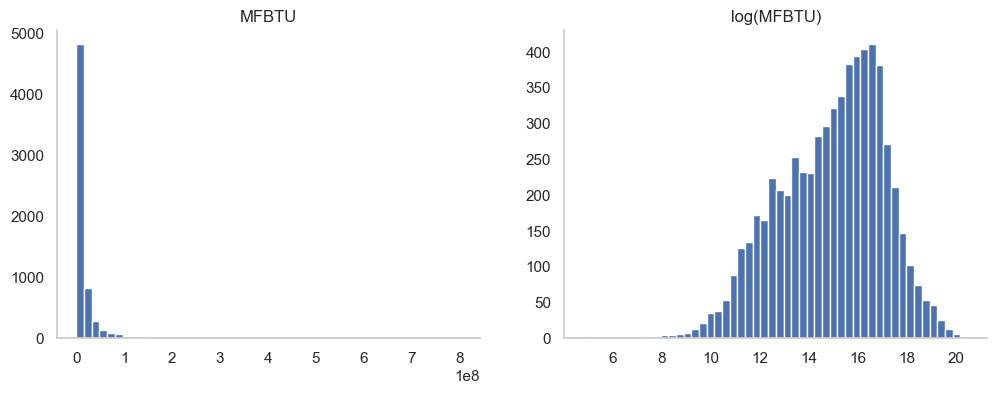

In [1779]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df["MFBTU"].dropna().hist(ax=ax[0], bins=50)
ax[0].set_title("MFBTU")
df["LOG_MFBTU"] = np.log(df["MFBTU"])
df["LOG_MFBTU"].dropna().hist(ax=ax[1], bins=50)
ax[1].set_title("log(MFBTU)")
for a in ax:
    a.grid(False)
plt.show()

# Data Cleaning Plan

_This logic is implemented in `02_build_dataset.py`. The notes below preserve my reasoning and document each decision so future readers (including future me) can follow along._

---

## Quick Outline
- [1. Replace NaNs with appropriate categories](#1-replace-nans-with-appropriate-categories)
- [2. Handle top-coded numeric values](#2-handle-top-coded-numeric-values)
- [3. One-off recodings](#3-one-off-recodings)
- [4. Consolidate seating capacity features](#4-consolidate-seating-capacity-features)
- [5. Remove obvious leakage columns](#5-remove-obvious-leakage-columns)
- [6. Renovation-since-2000 questions with missingness](#6-renovation-since-2000-questions-with-missingness)
- [7. Drop administrative survey flags](#7-drop-administrative-survey-flags)
- [8. Drop rows with missing target](#8-drop-rows-with-missing-target)

---

## 1. Replace NaNs with appropriate categories

> **Why**  
> Some categorical attributes can be reasonably inferred when missing—often meaning “No,” “None,” or a default ordinal bucket.

> **Example**  
> If the response to “number of underground floors” is `NA`, assume no basement: recode to `1` (i.e., “zero underground floors” in the survey’s 0/1/2 scheme).

> **Action**  
> - Identify variables where `NaN` plausibly equals “No/None/Default”.  
> - Impute with the corresponding categorical code (e.g., `0`, `1`, or `2`).  
> - Keep a changelog (boolean “_imputed” flag) if needed for auditability.

---

## 2. Handle top-coded numeric values

> **Why**  
> Some numeric fields use special high values to indicate “≥ top threshold.” Example: `NELVTR = 995` means “more than 30 elevators.”

> **Action**  
> - Replace special codes with the top value (e.g., `995 → 30` for `NELVTR`).  
> - Create a companion boolean feature `<col>_topcoded` to retain information about truncation.

> **Pattern**

| Variable | Top code | True top value | New value for top code | New flag              |
|---------:|:--------:|:--------------:|:-----------------------:|:----------------------|
| `NELVTR` |   995    |       30       |           30            | `NELVTR_topcoded = 1` |

---

## 3. One-off recodings

> **Why**  
> A handful of items have response options like “Don’t know” which behave like “No” for modeling and interpretability.

> **Example**  
> `DRVTHRU` (“Has a drive-thru window?”): recode “Don’t know” → “No”.

> **Action**  
> - Apply targeted recodes for these special cases.  
> - Document each transformation inline for traceability.

---

## 4. Consolidate seating capacity features

> **Why**  
> Multiple columns ask about seating capacity. Since facility type is already captured elsewhere, a single combined capacity attribute reduces redundancy.

> **Action**  
> - Merge overlapping seating capacity columns into one harmonized feature (e.g., `SEAT_CAPACITY_MAX`).  
> - Prefer the most informative/precise source when conflicts arise; otherwise use priority rules.

---

## 5. Remove obvious leakage columns

> **Why**  
> Any field that directly contains (or deterministically predicts) the target leaks information and inflates model performance.

> **Action**  
> - Identify and drop columns that are direct surrogates or post-outcome labels.

---

## 6. Renovation-since-2000 questions with missingness

> **Observation**  
> Wide missingness suggests many buildings were constructed after 2000, making renovation questions not applicable. Some items are also redundant or only asked conditionally after a “renovated” response.

> **Action**  
> - Where build year ≥ 2000, treat renovation items as "yes", as I suspect new and renovated buildings will behave similarly.  
> - De-duplicate highly collinear/conditional renovation fields.

---

## 7. Drop administrative survey flags

> **Why**  
> Operational flags (survey routing, quality-control markers, admin codes) do not represent building attributes and add noise.

> **Action**  
> - Remove all columns identified as administrative metadata.

---

## 8. Drop rows with missing target

> **Why**  
> Supervised learning requires observed targets. Keeping `NaN` targets complicates training/validation.

> **Action**  
> - Filter out rows where the target variable is `NaN` after all imputations/recode steps.

---

## Implementation Notes

- All transformations are implemented and formalized in a pipeline in `02_build_dataset.py`.

#### 1. Replace NaNs with other categories when appropriate

In [1780]:
def fill_many(df, cols, value):
    # keep only columns that exist
    use = [c for c in cols if c in df.columns]
    if not use:
        return 0  # nothing to do
    before = int(df[use].isna().sum().sum())
    df.loc[:, use] = df.loc[:, use].fillna(value)
    after = int(df[use].isna().sum().sum())
    return before - after  # number of cells filled

# Columns where we should set NA to 0
cols_na_to_0 = [
        "BASEMNT","NELVTR","NESLTR","DRYCL","RWSEAT","PBSEAT","EDSEAT","FDSEAT","HCBED",
        "RCACP_EL","PKGCP_EL","CHILP_EL","HTPCP_EL","ACWNWP_EL","EVAPP_EL","OTCLP_EL",
        "CHILP_NG","OTCLP_NG","CHILP_FK","OTCLP_FK","CHILP_PR","OTCLP_PR","CHILP_ST","OTCLP_ST",
        "CHWTP_CW","OTCLP_OT","SNACKSF","FASTFDSF","CAFSF","FDPREPSF","XRAYN","RFGRSN","RFGCOMPN",
        "RFGWIN","RFGOPN","RFGCLN","RFGVNN","RFGICN","RFGSTP","PCTERMN","LAPTPN","MLTMON","TABLETN",
        "SERVERN","LGOFFDEVN","SMOFFDEVN","WBOARDSN","TVVIDEON","RGSTRN","ATMN","LTZHRP","LTOHRP",
        "LTNHRP","BULBP","HALOP","HIDP","LEDP","OTLTP","PKLTN","DAYLTP", "NRSBED", "LODGRM"
          ]
# Columns where we should set NA to 1
cols_na_to_1 = ["FACDST","FACDHW","FACDCW","FACELC"]

# Columns where we should set NA to 2
cols_na_to_2 = ["VACANT"]

filled0 = fill_many(df, cols_na_to_0, 0)
filled1 = fill_many(df, cols_na_to_1, 1)
filled2 = fill_many(df, cols_na_to_2, 2)
print({"filled_zeroes": filled0, "filled_ones": filled1, "filled_twos": filled2})

{'filled_zeroes': 287027, 'filled_ones': 22860, 'filled_twos': 12558}


#### 2. Deal with top-coded values

In [1781]:
TOPCODE_SPECS = {
    "RWSEAT": (99995, 2000),
    "PBSEAT": (99995, 15000),
    "NELVTR": (995, 30),
    "NESLTR": (995, 10),
    "BASEMNT": (995, 5),
    "FLCEILHT": (995, 50),
    "HCBED": (9995, 250),
    "LODGRM": (99995, 250),
    "NRSBED": (9995, 250),
    "SERVERN": (9995, 500),
    "XRAYN": (995, 20),
    "RFGRSN": (99995, 1000),
    "RFGCOMPN": (99995, 1000),
    "LGOFFDEVN": (9995, 500),
    "SMOFFDEVN": (9995, 500),
    "WBOARDSN": (9995, 500),
    "TVVIDEON": (995,200)



}

for col, (sentinel, cap) in TOPCODE_SPECS.items():
    if col in df.columns:
        mask = df[col] == sentinel
        df[f"{col}_TOPCODED"] = mask.astype(int)
        df.loc[mask, col] = cap

# Deal with NFloor, which has several bins which need to be accounted for.
df["NFLOOR_10_14_BIN"] = (df["NFLOOR"] == 994).astype(int)
df["NFLOOR_TOP_BIN"] = (df["NFLOOR"] == 995).astype(int)
df["NFLOOR"] = df["NFLOOR"].replace({994: 12, 995: 15})

#### 3. Address one-off recodings

In [1782]:
# Misc one-off to recode
# "Don't know if drive-thru".. assuming you don't have a drive thru if you responded "don't know".
# Recode as "No"
df["DRVTHRU"] = df["DRVTHRU"].replace({5: 2})

# Number of occupants has a confidentiality code.
# Will impude  recode and give flag
mask = df["NOCC"].eq(996)
df["NOCC_IMPUTED_FLAG"] = mask.astype(int)
df.loc[mask, "NOCC"] = df.loc[~mask, "NOCC"].median()

# Percent of year occupied..
# 0 is an option and 0 occurs many times in dataset.
# will median impute + flag.
m = df["OCCUPYP"].isna()
df["OCCUPYP_IMPUTED"] = m.astype(int)
df.loc[m, "OCCUPYP"] = df.loc[~m, "OCCUPYP"].median()

#### 4. Create new attribute to deal with many columns asking about seating capacity

In [1783]:
seat_cols = ["RWSEAT","PBSEAT","EDSEAT","FDSEAT"]

df["SEATS_TOTAL"] = df[seat_cols].sum(axis=1, min_count=1)
flag_cols = ["RWSEAT_TOPCODED","PBSEAT_TOPCODED"]
if flag_cols:
    df["SEATS_TOPCODED"] = df[flag_cols].max(axis=1)
    df.drop(columns=flag_cols, inplace=True, errors="ignore")
df.drop(columns=seat_cols, inplace=True, errors="ignore")

#### 5. Remove columns that will cause obvious leakage

In [1784]:
leakage = ["MFEXP","ELBTU","ELCNS","ELEXP","NGBTU","NGCNS","NGEXP",
           "MFHTBTU","MFCLBTU","MFVNBTU","MFWTBTU","MFLTBTU","MFCKBTU",
           "MFRFBTU","MFOFBTU","MFPCBTU","MFOTBTU","ELHTBTU","ELCLBTU",
           "ELVNBTU","ELWTBTU","ELLTBTU","ELCKBTU","ELRFBTU","ELOFBTU",
           "ELPCBTU","ELOTBTU","NGHTBTU","NGCLBTU","NGWTBTU","NGCKBTU","NGOTBTU",
            "FKBTU", "FKCNS", "FKEXP", "DHBTU", "DHHTBTU", "DHCLBTU", "DHWTBTU", 
            "DHCKBTU", "DHOTBTU", "DHEXP", "FKOTBTU", "FKHTBTU", "FKCLBTU",
            "FKCKBTU", "WOEXP", "FKWTBTU"]

weights = df.filter(regex=r"^FINALWT\d*$", axis=1).columns.tolist()
obvious = [c for c in ["SQFTC","ELEVTR","ESCLTR","PUBID","NOCCAT","WKHRSC","NWKERC","LZHRPC","LOHRPC","LNHRPC"] if c in df.columns]

to_drop = [c for c in leakage + weights + obvious if c in df.columns]
df = df.drop(columns=to_drop, errors="ignore")
print("Dropped", len(to_drop), "columns.")

Dropped 210 columns.


#### 6. Renovation detail fields behave like one signal

Hypothesis. The detailed renovation fields (`RENCOS`, `RENADD`, `RENRDC`, `RENINT`, `RENRFF`, `RENWIN`, `RENHVC`, `RENLGT`, `RENPLB`, `RENELC`, `RENINS`, `RENSAF`, `RENSTR`, `RENOTH`) are all subquestions that come after "did you renovate afte the year 2000?" I.e., if you said "no" to this question, then you weren't asked any of the followup questions and your response is blank here.

Test plan
	1.	NA rates: compute the missing fraction for RENOV and each detail column to see if rates are similar.
	2.	Row-wise missingness: verify that the same rows are missing across all detail columns (identical NA masks).

Why this is reasonable
	•	Identical missingness suggests the detail columns don’t add independent information.
	•	Simplifying to RENOV reduces dimensionality without losing signal.
	•	The RENOV = 1 imputation is explicitly documented and can be revisited in sensitivity checks.

         na_rate
RENOV   0.063393
RENCOS  0.441734
RENADD  0.441734
RENRDC  0.441734
RENINT  0.441734
RENRFF  0.441734
RENWIN  0.441734
RENHVC  0.441734
RENLGT  0.441734
RENPLB  0.441734
RENELC  0.441734
RENINS  0.441734
RENSAF  0.441734
RENSTR  0.441734
RENOTH  0.441734
All renovation detail columns share the same missingness pattern: True


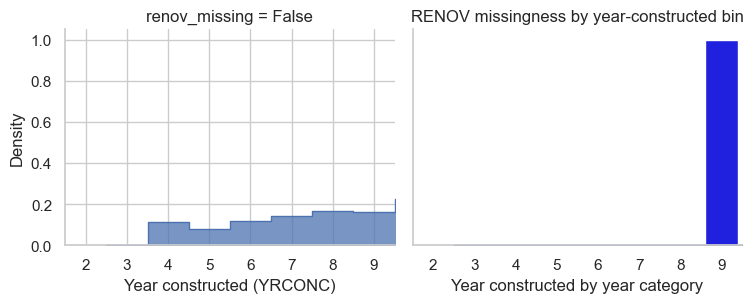

In [1785]:
# --- Renovation subfields: inspect → plot → then mutate df ---

renov_subs = ["RENCOS","RENADD","RENRDC","RENINT","RENRFF","RENWIN",
              "RENHVC","RENLGT","RENPLB","RENELC","RENINS","RENSAF","RENSTR","RENOTH"]

# 1) Quick peek: NA rates
print(df[["RENOV"] + renov_subs].isna().mean().sort_values().to_frame("na_rate"))

# 2) Do they go missing on the same rows?
base_mask = df[renov_subs[0]].isna()
same_missing = True
for c in renov_subs[1:]:
    if not (df[c].isna() == base_mask).all():
        same_missing = False
        print(f"Missingness differs for column: {c}")
        break
print(f"All renovation detail columns share the same missingness pattern: {same_missing}")

# 3) Visualize RENOV missingness by YRCONC (uses raw CSV, i.e., before any fills/drops)
plot_df = pd.read_csv(RAW_DIR / "cbecs_2018_microdata.csv")
plot_df["RENOV_missing"] = plot_df["RENOV"].isna()

plot_df = df.assign(renov_missing=df["RENOV"].isna())
bins = np.arange(0.5, 9.5 + 1, 1)

# Creating the displot for RENOV missingness
g = sns.displot(
    data=plot_df,
    x="YRCONC",
    col="renov_missing",
    element="step",
    stat="density",
    common_norm=False,
    height=3.2,
    aspect=1.2,
    bins=bins
)
g.set_axis_labels("Year constructed (YRCONC)", "Density")

# Create a bar plot for RENOV missingness by Year Constructed (YRCONC)
# Replace `gp` with `g` and plot the bar chart for missingness
ax = sns.barplot(
    x="YRCONC", 
    y="renov_missing", 
    data=plot_df, 
    estimator=lambda x: np.mean(x), 
    ci=None, 
    color="blue"
)
ax.set_ylabel("Fraction missing (RENOV)")
ax.set_xlabel("Year constructed by year category")
ax.set_title("RENOV missingness by year-constructed bin")
ax.grid(False)

plt.tight_layout()
plt.show()

# Fill NA in RENOV with 1 since I imagine buildings built after 2000 will behave more like those renovated after 2000 than those that weren't
df[["RENOV"] + renov_subs].fillna(1, inplace=True)

#### Drop columns that are administrative survey flags

I consider these “administrative flags” and remove them for the initial modeling pass.

In [1786]:
import numpy as np
import pandas as pd

def is_0_1_9_only(s: pd.Series) -> bool:
    """
    Returns True if (ignoring NaN) the unique numeric values in the column
    are a subset of {0,1,9}.
    """
    vals = s.dropna().unique()
    return len(vals) > 0 and set(np.unique(vals)).issubset({0, 1, 9})

flag_cols = [c for c in df.columns if is_0_1_9_only(df[c])]
print(f"Identified {len(flag_cols)} trivial flag columns to drop (examples): {flag_cols[:12]}")

df = df.drop(columns=flag_cols, errors="ignore")
print(f"Shape after dropping flag cols: {df.shape}")

Identified 539 trivial flag columns to drop (examples): ['HTLS50', 'DIST_ST', 'DIST_HW', 'FURNAC_CO', 'BLRAIR_HT1', 'BLRFNCL_HT1', 'BLRDUCT_HT1', 'BLRRAD_HT1', 'BLRRDFL_HT1', 'BLRWTLP_HT1', 'BLROTD_HT1', 'BLRAIR_EL2']
Shape after dropping flag cols: (6436, 518)


# Post-cleaning data visualizations

<Figure size 1400x1200 with 0 Axes>

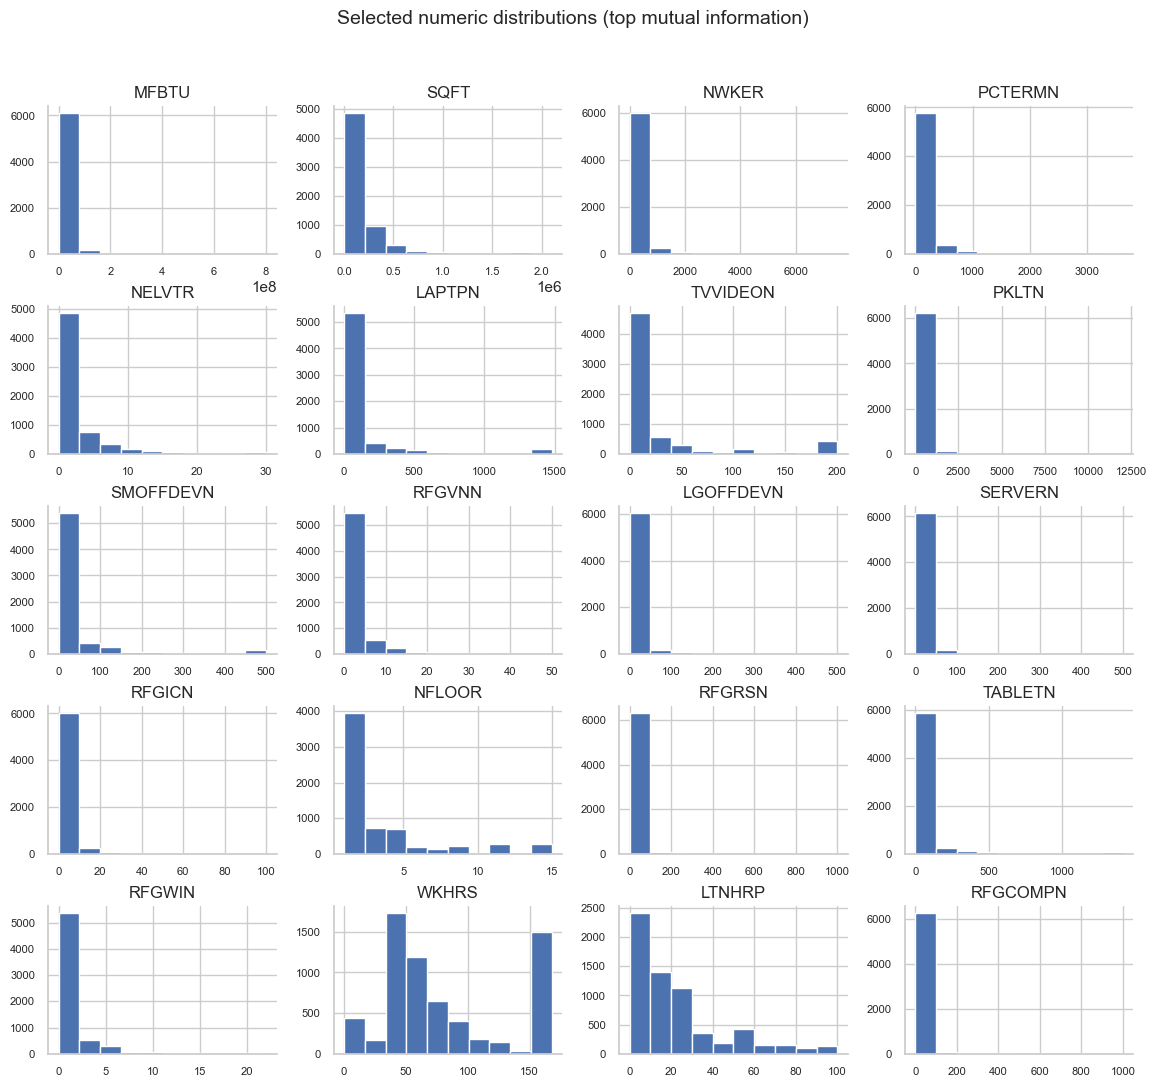

In [1787]:
# --- CONFIG: set your target column name here (or pass y separately) ---
y_name = "LOG_MFBTU"            # <-- change to your target col in df

# 1) pick numeric candidates and optionally filter high-missingness/constant cols
numeric_plot_cols = [c for c in numeric_cols if c in df.columns]
X = df[numeric_plot_cols].copy()

# drop very-missing columns (e.g., >30% NaN) and near-constants
keep = (X.isna().mean() <= 0.30) & (X.nunique(dropna=True) > 1)
X = X.loc[:, keep]

# 2) align with target and impute NaNs (MI requires finite values)
y = df[y_name]
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]
X = X.fillna(X.median(numeric_only=True))

# 3) choose MI function (classification vs regression)
is_classification = (y.dtype.kind in "biu") or (pd.api.types.is_categorical_dtype(y)) \
                    or (y.nunique() <= 20 and not pd.api.types.is_float_dtype(y))

if is_classification:
    mi_vals = mutual_info_classif(X, y, random_state=0, discrete_features=False)
else:
    mi_vals = mutual_info_regression(X, y, random_state=0)

mi = pd.Series(mi_vals, index=X.columns)

# 4) rank by MI and take top 20
num_rank = mi.sort_values(ascending=False).head(20).index.tolist()

# 5) plot (same as before)
plt.figure(figsize=(14,12))
axes = df[num_rank].hist(figsize=(14,12), layout=(5,4), sharex=False, sharey=False)
plt.subplots_adjust(top=0.90, hspace=0.35, wspace=0.25)
plt.suptitle("Selected numeric distributions (top mutual information)", fontsize=14)
for ax in np.ravel(axes):
    ax.tick_params(labelsize=8)

Wow, a ton of my variables are log-normally distributed. This will have to be addressed when I get to linear modeling.

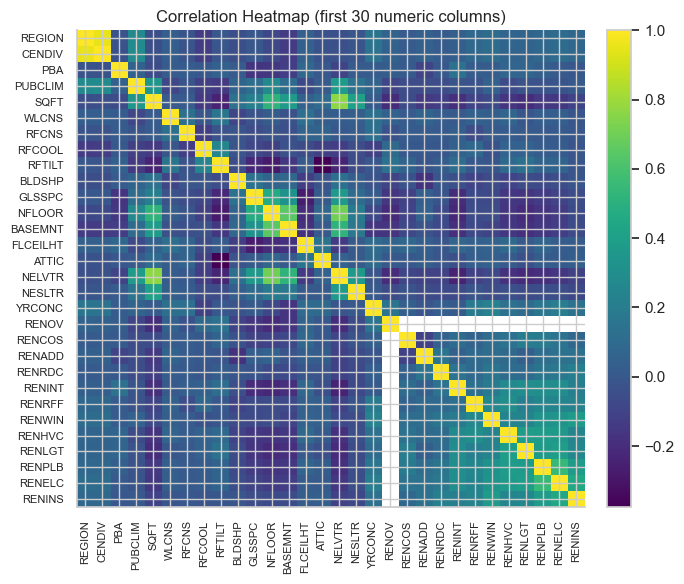

In [1788]:
# 4.3 Quick numeric correlation heatmap (subset for visibility)
# Use only numeric columns and cap at 25 to keep the heatmap readable for the portfolio
num_only = df.select_dtypes(include=[np.number]).copy()
cols_for_corr = num_only.columns[:30]
corr = num_only[cols_for_corr].corr()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr, cmap="viridis", aspect="auto")
ax.set_xticks(np.arange(len(cols_for_corr)))
ax.set_yticks(np.arange(len(cols_for_corr)))
ax.set_xticklabels(cols_for_corr, rotation=90, fontsize=8)
ax.set_yticklabels(cols_for_corr, fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (first 30 numeric columns)")
plt.tight_layout()
plt.show()

Looks like most of the variables are log-normally distributed like the target variable. Won't have to deal with this for training a random forest to quickly check feature importances, but will likely have to deal in training linear models. This is likely to also have influenced 

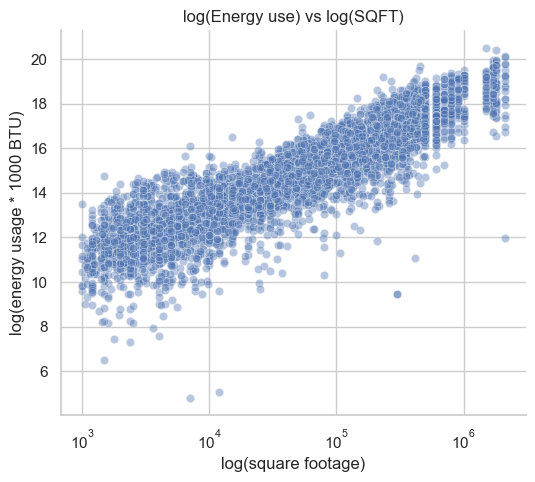

In [1810]:
# Common physical scaling diagnostic
plt.figure(figsize=(6,5))
sns.scatterplot(x="SQFT", y="LOG_MFBTU", data=df,  alpha=0.4)
plt.xscale("log")
plt.title(f"log(Energy use) vs log(SQFT)"
          )
plt.xlabel("log(square footage)")
plt.ylabel("log(energy usage * 1000 BTU)")
plt.show()

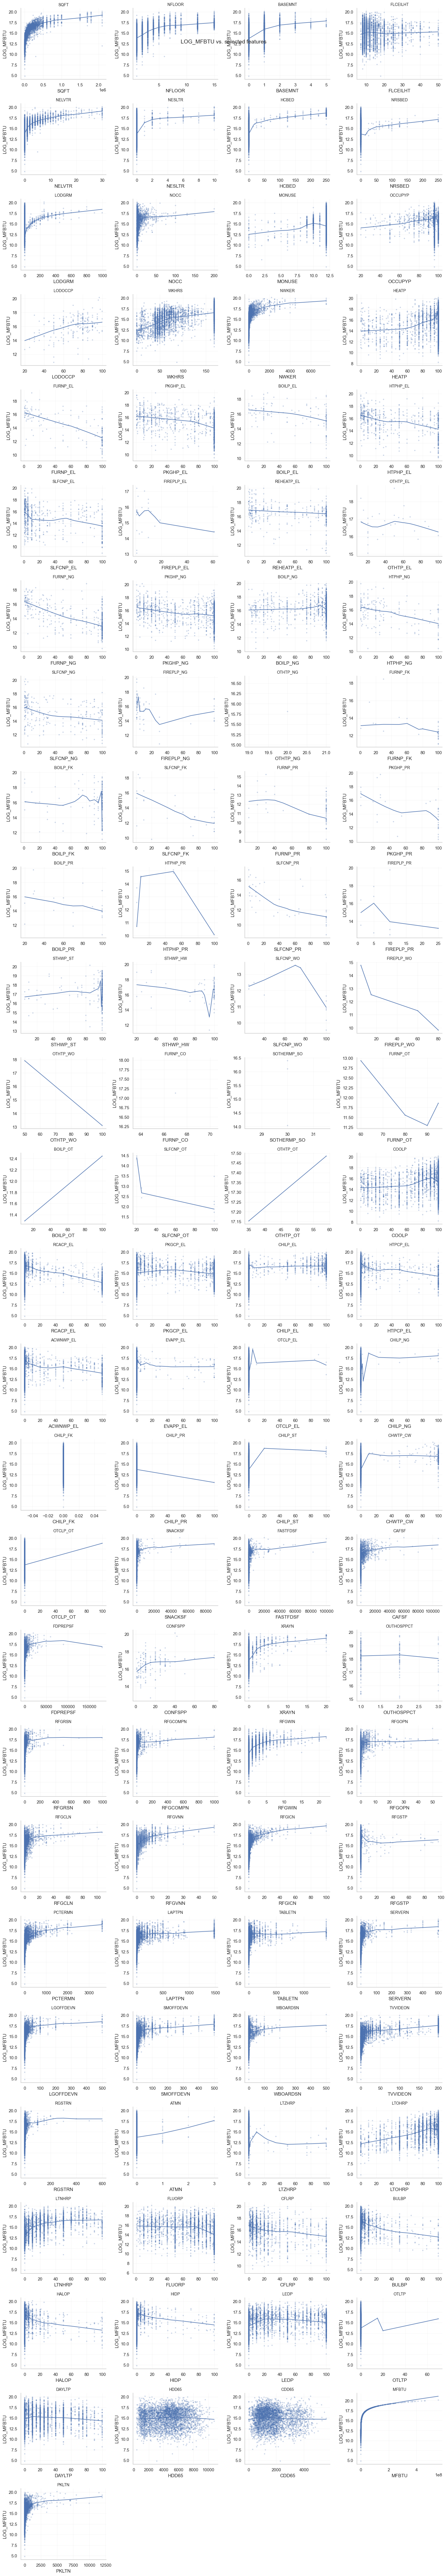

[info] skipped features:
  - OTHTP_FK: constant/all-NaN
  - OTHTP_PR: constant/all-NaN
  - FURNP_WO: constant/all-NaN
  - BOILP_CO: constant/all-NaN
  - OTHTP_CO: constant/all-NaN
  - PKGHP_OT: constant/all-NaN


In [1790]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_features_vs_target(
    df: pd.DataFrame,
    features: list,
    target: str,
    *,
    max_cols: int = 4,
    sample: int | None = 4000,   # downsample for speed/clarity; None = no sampling
    alpha: float = 0.3,
    s: int = 10,                 # marker size
    lowess: bool = True,         # add LOWESS smoother (via regplot)
    drop_const: bool = True,     # skip constant/all-NaN features
    sharey: bool = False,
):
    # resolve feature names (STRICT: only use names exactly as provided)
    resolved = []
    skipped = []
    for c in features:
        if c in df.columns:
            if drop_const:
                ser = df[c]
                if ser.nunique(dropna=True) <= 1:
                    skipped.append((c, "constant/all-NaN"))
                    continue
            if pd.api.types.is_numeric_dtype(df[c]):
                resolved.append(c)
            else:
                skipped.append((c, "non-numeric"))
        else:
            skipped.append((c, "not found"))

    if target not in df.columns:
        raise ValueError(f"Target '{target}' not in DataFrame columns.")
    if not pd.api.types.is_numeric_dtype(df[target]):
        raise ValueError(f"Target '{target}' must be numeric.")

    if not resolved:
        raise ValueError("No plottable features after filtering.")

    # optional sampling (same rows used across all panels)
    plot_df = df[[target] + resolved].dropna(subset=[target]).copy()
    if sample is not None and len(plot_df) > sample:
        plot_df = plot_df.sample(sample, random_state=42)

    n = len(resolved)
    ncols = min(max_cols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.0*ncols, 3.4*nrows), sharey=sharey)
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(resolved):
        ax = axes[i]
        sns.regplot(
            data=plot_df,
            x=col, y=target,
            scatter_kws=dict(alpha=alpha, s=s, edgecolor="none"),
            lowess=lowess,
            line_kws=dict(alpha=0.9, lw=1.5),
            ax=ax
        )
        ax.set_title(col, fontsize=10)
        ax.grid(True, alpha=0.15)

    # hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(f"{target} vs. selected features", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()

    if skipped:
        print("[info] skipped features:")
        for name, reason in skipped[:12]:
            print(f"  - {name}: {reason}")
        if len(skipped) > 12:
            print(f"  ... and {len(skipped)-12} more")

numeric_plot_cols = [c for c in numeric_cols if c in df.columns]   # your list
plot_features_vs_target(df, numeric_plot_cols, target="LOG_MFBTU")

KeyError: 'SOTHERMP_CO'

Tons of features are obviously log-normally distributed, and som ethers show little relationship with the target variable.

#### Remove all rows where target value is NaN

In [1791]:
# Remove rows
df = df.dropna(subset = ["MFBTU"])

# Now I'll train a quick random forest model to explore preliminary feature importances

In [1792]:
# Use the yaml created in pipeline step 00_parse_codebook.py to one hot encode all categorical variables.

# Load the YAML file which contains the variable types (categorical and numeric variables)
data_types = yaml.safe_load(open(PROJ / "conf" / "variable_types.yaml"))

# Extract the list of categorical variables from the YAML data
cat_cols = data_types['categorical_variables']
numeric_cols = data_types['numeric_variables']

# # Ensure that only columns that actually exist in the DataFrame are used
cols_to_ohe = [col for col in cat_cols if col in df.columns]
cols_to_fill_na = [col for col in numeric_cols if col in df.columns]



# Print out the lengths of columns in the dataframe and the categorical columns to debug
print(f"Total columns in DataFrame: {len(df.columns)}")
print(f"Categorical columns to OHE: {len(cols_to_ohe)}")
print(f"Numeric columns: {len(cols_to_fill_na)}")


# Drop the original categorical columns before applying OHE to avoid redundancy
df_dropped_categorical = df.loc[:,cols_to_fill_na]

# Step 2: Apply One-Hot Encoding (OHE) to the categorical columns only
# Replace missing values (NaN) in categorical columns with the string "missing"
# and apply pd.get_dummies for OHE. 
df_categorical_dummies = pd.get_dummies(df.loc[:, cols_to_ohe].fillna("missing").astype('category'), drop_first=True)



# Step 3: Handle missing values in numeric columns by creating dummy columns for NaNs
# For each numeric column, create a new column indicating whether it was NaN
for col in numeric_cols:
    if col in df_dropped_categorical.columns:  # Ensure the column is in the dataframe
        # Create a new column for NaN indicators (1 where NaN, 0 otherwise)
        df_dropped_categorical[f"{col}_is_na"] = df_dropped_categorical[col].isna().astype(int)
        
        # Replace NaN with 0 in the original numerical columns
        df_dropped_categorical[col] = df_dropped_categorical[col].fillna(0)

# Step 4: Concatenate the One-Hot Encoded categorical columns with the non-categorical columns
# The ~cols_to_ohe negates the mask to select the columns that are not categorical
df_ohe_all = pd.concat([df_dropped_categorical, df_categorical_dummies], axis=1)

# Step 5: Apply Variance Threshold to remove low-variance features
sel = VarianceThreshold(threshold=0.05)

# Fit the selector to the data and transform it to remove low-variance features
df_transformed = sel.fit_transform(df_ohe_all)

# Get the feature names that were kept after applying the variance threshold
selected_columns = df_ohe_all.columns[sel.get_support()]

# Convert the transformed array back into a pandas DataFrame
df_final = pd.DataFrame(df_transformed, columns=selected_columns)

# Now 'df_final' contains only the features with variance >= 0.1
print(df_final.head())

# Check the number of features remaining after pruning
print(f"Number of features after variance pruning: {df_final.shape[1]}")

Total columns in DataFrame: 518
Categorical columns to OHE: 405
Numeric columns: 111
       SQFT  NFLOOR  BASEMNT  FLCEILHT  NELVTR  NESLTR  HCBED  NRSBED  LODGRM  NOCC  MONUSE  OCCUPYP  LODOCCP  WKHRS  NWKER  HEATP  FURNP_EL  PKGHP_EL  \
0  210000.0    12.0      1.0      12.0     8.0     0.0    0.0     0.0     0.0   1.0    12.0    100.0      0.0   70.0  350.0  100.0       0.0       0.0   
1   28000.0     5.0      1.0       8.0     1.0     0.0    0.0     0.0     0.0   2.0    12.0    100.0      0.0   45.0   12.0   80.0       0.0       0.0   
2    2100.0     1.0      0.0       9.0     0.0     0.0    0.0     0.0     0.0   1.0    12.0    100.0      0.0   48.0    6.0  100.0       0.0     100.0   
3  240000.0     1.0      0.0      25.0     0.0     0.0    0.0     0.0     0.0   2.0    12.0     96.0      0.0   55.0   34.0    5.0       0.0       0.0   
4  295000.0     1.0      0.0      30.0     0.0     0.0    0.0     0.0     0.0   2.0    12.0     96.0      0.0   80.0   10.0  100.0       0.0     

In [1793]:
# Now we'll train a random forest...
# Fit Random Forest model
X = df_final.drop(["MFBTU"], axis=1)
y = np.log(df_final.MFBTU)


x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.7,random_state = 10)
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(x_train, y_train)  # Assuming X is your feature matrix and y is your target variable


RandomForestRegressor(random_state=1)

In [1794]:
# Predict on new data
y_pred = rf.predict(x_test)

# Example of getting feature importance
importances = rf.feature_importances_

# Calculate the R² score for both training and testing sets
train_score = rf.score(x_train, y_train)  # R² score on the training data
test_score = rf.score(x_test, y_test)  # R² score on the test data

# Print the scores
print(f"Train R² score: {train_score:.4f}")
print(f"Test R² score: {test_score:.4f}")

# Create a DataFrame with feature names and their importances
features_df = pd.DataFrame({
    'Feature': X.columns,  # Feature names
    'Importance': importances  # Feature importances
})

# Sort the features by importance (descending order)
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(features_df.head(20))

Train R² score: 0.9872
Test R² score: 0.9082
             Feature  Importance
0               SQFT    0.808278
14             NWKER    0.017071
13             WKHRS    0.012163
75            RFGWIN    0.008223
129            PBA_5    0.007720
52             COOLP    0.006478
6              HCBED    0.006429
515      WHRECOV_2.0    0.005832
516  WHRECOV_missing    0.005734
4             NELVTR    0.005209
15             HEATP    0.005197
81           PCTERMN    0.005129
91            LTOHRP    0.003553
101            HDD65    0.003267
437  BOOSTWT_missing    0.002595
102            CDD65    0.002516
92            LTNHRP    0.002422
3           FLCEILHT    0.002138
90            LTZHRP    0.001859
89            RGSTRN    0.001817


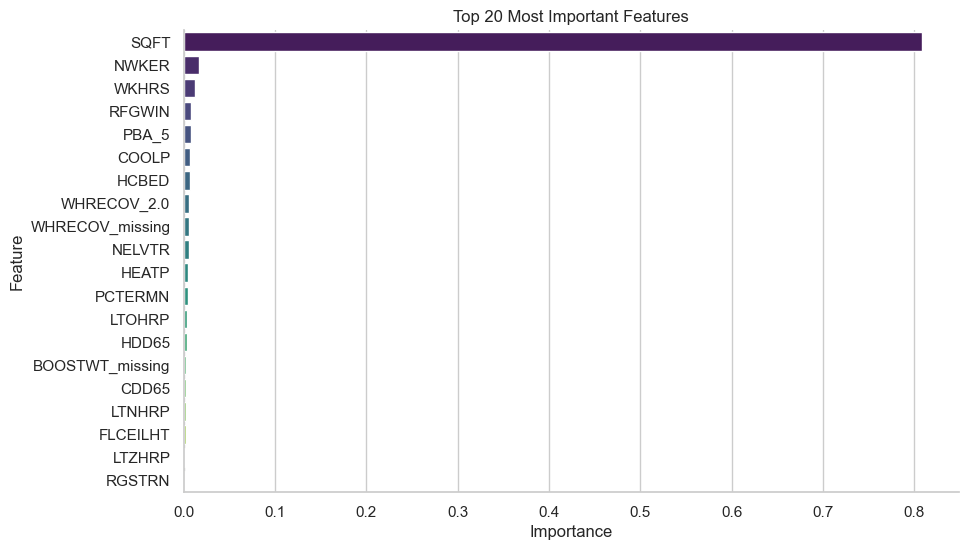

(6357, 599)

In [1795]:
# Sort the features by importance
top_features = features_df.sort_values(by='Importance', ascending=False).head(20)

# Plotting the top 20 most important features using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
X.shape

# Now it's time to clean the dataset and prepare it for some preliminary feature screening

There are 1730 buildings built after 2000 and only 400 missing values.
RENOV     0.062923
RENCOS    0.437471
RENADD    0.437471
RENRDC    0.437471
RENINT    0.437471
RENRFF    0.437471
RENWIN    0.437471
RENHVC    0.437471
RENLGT    0.437471
RENPLB    0.437471
RENELC    0.437471
RENINS    0.437471
RENSAF    0.437471
RENSTR    0.437471
RENOTH    0.437471
dtype: float64
It is True that all missing rows are the same.
Dropped 14 renovation detail columns.


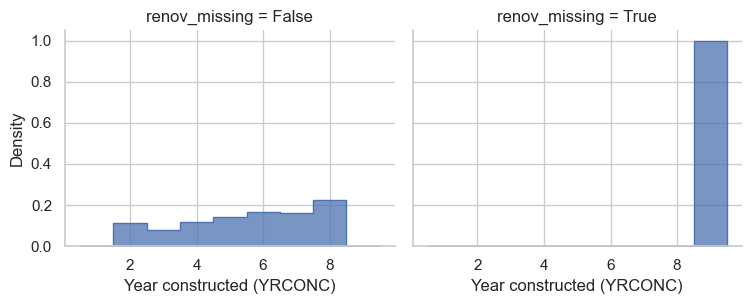

In [1796]:
# There is a series of attributes where the question asked is "Was there X type of renovation done before the year 2000?" 
# Need to check and make sure there isn't a pattern in this type of attribute when it's missing.
# I.e. is it possible that all values of NA are jus buildings built after 2000?

buildings_built_after_2000 = np.sum(df.YRCONC == 8) + np.sum(df.YRCONC==9)
missing_renovations = np.sum(df.RENOV.isna())

print(f"There are {buildings_built_after_2000} buildings built after 2000 and only {missing_renovations} missing values.")

plot_df = df.assign(renov_missing=df["RENOV"].isna())
bins = np.arange(0.5, 9.5 + 1, 1)
g = sns.displot(
    data=plot_df,
    x="YRCONC",
    col="renov_missing",
    element="step",
    stat="density",
    common_norm=False,
    height=3.2,
    aspect=1.2,
    bins=bins
)
g.set_axis_labels("Year constructed (YRCONC)", "Density")

# Check if the other RENOV subcategories are related?
# (Trial & error notes)
# I suspected the detailed renovation fields were "weirdly NA", so I started by eyeballing their NA rates one by one…

renov_subs = ["RENCOS","RENADD","RENRDC","RENINT","RENRFF","RENWIN",
              "RENHVC","RENLGT","RENPLB","RENELC","RENINS","RENSAF","RENSTR","RENOTH"]

# 1) Quick peek: are they all missing at about the same rate?
print(df[["RENOV"] + renov_subs].isna().mean().sort_values())

# 2) These sub-items look identical. I'll now confirm that these are all the same missing rows in each column.
base_mask = df[renov_subs[0]].isna()
sanity_check = all((df[c].isna() == base_mask).all() for c in renov_subs)
print(f"It is {sanity_check} that all missing rows are the same.")

# 4) Given this, I’m dropping the detailed subcategories for modeling and keeping higher-level signals only.
df = df.drop(columns=renov_subs)
print(f"Dropped {len(renov_subs)} renovation detail columns.")

# I'll also fill all NA values in RENOV with a 1, since they're new buildings. They'll likely behave more like 
# newly renovated buildings than older buildings which haven't been renovated.
df.loc[:,"RENOV"] = df["RENOV"].fillna(1)

In [1797]:

# 0) Create Target Variable
if "MFBTU" in df.columns:
    df = df.dropna(subset=["MFBTU"])
    df = df[df["MFBTU"] > 0]
    df["LOG_MFBTU"] = np.log(df["MFBTU"])

# 1) Identify trivial flag columns (only {0,1,9}) to drop later
def _is_0_1_9_only(s: pd.Series):
    # coerce to numeric (just in case); ignore non-numeric silently
    vals = pd.to_numeric(s, errors="coerce").dropna().unique()
    return len(vals) > 0 and set(vals).issubset({0, 1, 9})

flags_to_remove = [c for c in df.columns if _is_0_1_9_only(df[c])]

# 2) Grouped fillna (batch operations)
cols_0 = ["BASEMNT","NELVTR","NESLTR","DRYCL","RWSEAT","PBSEAT","EDSEAT","FDSEAT","HCBED",
          "RCACP_EL","PKGCP_EL","CHILP_EL","HTPCP_EL","ACWNWP_EL","EVAPP_EL","OTCLP_EL",
          "CHILP_NG","OTCLP_NG","CHILP_FK","OTCLP_FK","CHILP_PR","OTCLP_PR","CHILP_ST","OTCLP_ST",
          "CHWTP_CW","OTCLP_OT","SNACKSF","FASTFDSF","CAFSF","FDPREPSF","XRAYN","RFGRSN","RFGCOMPN",
          "RFGWIN","RFGOPN","RFGCLN","RFGVNN","RFGICN","RFGSTP","PCTERMN","LAPTPN","MLTMON","TABLETN",
          "SERVERN","LGOFFDEVN","SMOFFDEVN","WBOARDSN","TVVIDEON","RGSTRN","ATMN","LTZHRP","LTOHRP",
          "LTNHRP","BULBP","HALOP","HIDP","LEDP","OTLTP","PKLTN","DAYLTP"]
cols_1 = ["RENOV","FACDST","FACDHW","FACDCW","FACELC"]
cols_2 = ["VACANT","DRVTHRU"]

df[list(set(cols_0) & set(df.columns))] = df[list(set(cols_0) & set(df.columns))].fillna(0)
df[list(set(cols_1) & set(df.columns))] = df[list(set(cols_1) & set(df.columns))].fillna(1)
df[list(set(cols_2) & set(df.columns))] = df[list(set(cols_2) & set(df.columns))].fillna(2)

# 3) One-off recodes (guarded)
if "DRVTHRU" in df.columns:
    # "5 = don't know" -> treat as "2 = no"
    df.loc[df["DRVTHRU"] == 5, "DRVTHRU"] = 2

# 4) Top-code handling (cap and add *_TOPCODED indicator) in one pass
TOPCODE_SPECS = {
    "RWSEAT": (99995, 2000),
    "PBSEAT": (99995, 15000),
    "NELVTR": (995, 30),
    "NESLTR": (995, 10),
    "BASEMNT": (995, 5),
    "FLCEILHT": (995, 50),
    "HCBED": (9995, 250),
    "LGOFFDEVN": (9995, 500),
    "SMOFFDEVN": (9995, 500),
    "WBOARDSN": (9995, 200),
    "TVVIDEON": (9995, 200),
}
top_indicators = {}
for col, (sentinel, cutoff) in TOPCODE_SPECS.items():
    if col not in df.columns:
        continue
    # ensure numeric comparison works
    df[col] = pd.to_numeric(df[col], errors="coerce")
    mask = df[col].eq(sentinel)
    top_indicators[f"{col}_TOPCODED"] = mask.astype(int)
    df.loc[mask, col] = cutoff
if top_indicators:
    df = df.assign(**top_indicators)

# 5) NFLOOR: create bins + replace midpoints (guarded)
if "NFLOOR" in df.columns:
    df["NFLOOR_10_14_BIN"] = (df["NFLOOR"] == 994).astype(int)
    df["NFLOOR_TOP_BIN"]  = (df["NFLOOR"] == 995).astype(int)
    df["NFLOOR"] = df["NFLOOR"].replace({994: 12, 995: 15})



# 6) Seat features: make SEATS_TOTAL + SEATS_TOPCODED, then drop parts
seat_parts = [c for c in ["RWSEAT","PBSEAT","EDSEAT","FDSEAT"] if c in df.columns]
top_flags  = [c for c in ["RWSEAT_TOPCODED","PBSEAT_TOPCODED"] if c in df.columns]
assign_seats = {}
if seat_parts:
    assign_seats["SEATS_TOTAL"] = df[seat_parts].sum(axis=1, min_count=1)
if top_flags:
    assign_seats["SEATS_TOPCODED"] = df[top_flags].max(axis=1)
if assign_seats:
    df = df.assign(**assign_seats)
    df = df.drop(columns=[c for c in seat_parts + top_flags if c in df.columns])

# 7) Drop leakage + obvious drops + survey weights + trivial flags in one shot
leakage_risks = [
    "MFEXP","ELBTU","ELCNS","ELEXP","NGBTU","NGCNS","NGEXP",
    "MFHTBTU","MFCLBTU","MFVNBTU","MFWTBTU","MFLTBTU","MFCKBTU",
    "MFRFBTU","MFOFBTU","MFPCBTU","MFOTBTU","ELHTBTU","ELCLBTU",
    "ELVNBTU","ELWTBTU","ELLTBTU","ELCKBTU","ELRFBTU","ELOFBTU",
    "ELPCBTU","ELOTBTU","NGHTBTU","NGCLBTU","NGWTBTU","NGCKBTU","NGOTBTU",
]
obvious_drops = ["SQFTC","ELEVTR","ESCLTR","PUBID","NOCCAT","WKHRSC","NWKERC","LZHRPC","LOHRPC","LNHRPC"]
weights_to_drop = df.filter(regex=r"^FINALWT\d*$").columns.tolist()

drop_cols = set(leakage_risks + obvious_drops + weights_to_drop + flags_to_remove)
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# 9) Sparsity-based column prune (optional; keep columns where >= (1 - missing_threshold) are non-null)
missing_threshold = 0.9  # drop columns with >90% missing
keep_min = int((1 - missing_threshold) * len(df))
df = df.dropna(axis=1, thresh=keep_min)

# 10) Final defragment for speed
df = df.copy()


# Use a ran


# # Use Variance to remove low-variance features..
# sel = VarianceThreshold(threshold=0.1)  # Can adjust the threshold for near-constant features

# # Apply VarianceThreshold and transform the data
# df_transformed = sel.fit_transform(df)

# # Get the selected column names based on the original DataFrame's columns
# selected_columns = df.columns[sel.get_support()]

# # Create a new DataFrame with the selected columns
# df = pd.DataFrame(df, columns=selected_columns)

# # Check the number of features remaining after pruning
# print(f"Number of features after variance pruning: {df.shape[1]}")


# print(f"Number of features after dropping weights: {df.shape[1]}")





# "FACIL", "FACACT", "PLANT", "BLDPLT", "GOVTYP", "OWNTYPE",
  #  "OWNOCC", "NWNOPR", "WHOPPR", "FKTYPE", "HEATP", "PKGHT", "FURNAC", "SLFCON",
   # "BOILER", "HTPMPH","STHW", "REHEAT","FIREPLC","OTHEQ","PKGHT_EL",





In [1798]:
y = df["LOG_MFBTU"]
X = df.drop(columns=["MFBTU", "LOG_MFBTU"], errors="ignore").copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
CAT_MAX_UNIQUE = 30

cat_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= CAT_MAX_UNIQUE]
num_cols = [c for c in X.columns if c not in cat_cols]

In [1799]:
# from sklearn.ensemble import RandomForestRegressor
# import matplotlib.pyplot as plt


# # Define columns to go into scikit learn
# y = df["LOG_MFBTU"]
# X = df.drop(["MFBTU", "LOG_MFBTU"], axis = 1)

# # Fit Random Forest model
# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X, y)  # Assuming X is your feature matrix and y is your target variable


In [1800]:
# feature_names = X.columns

# # Get feature importances
# importances = model.feature_importances_

# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     "Importance": importances
# })

# # Sort the DataFrame by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Print the top 10 most important features
# print(importance_df.head(10))

# # Plot the feature importances
# plt.figure(figsize=(10, 6))

# # Use iloc to select the top 10 features by position
# plt.barh(importance_df.iloc[:10]['Feature'], importance_df.iloc[:10]['Importance'])

# plt.xlabel('Importance')
# plt.title('Feature Importances from Random Forest')
# plt.show()

In [1801]:
# # Now let's drop a bunch of poorly performing features and try again...
# # Define a threshold for feature importance (e.g., 0.01)
# threshold = 0.001

# # Select features with importance above the threshold
# selected_features = importance_df[importance_df['Importance'] > threshold]['Feature']

# # Filter the dataset to keep only the selected features
# X_selected = X[selected_features]

# print(f"Selected features after applying threshold: {selected_features.tolist()}")

# # Fit Random Forest model
# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X_selected, y)  # Assuming X is your feature matrix and y is your target variable

# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     "Importance": importances
# })

# # Sort the DataFrame by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Print the top 10 most important features
# print(importance_df.head(10))




In [1802]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_selected,y, test_size = 0.8, random_state=1)


# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X_train,y_train)



# train_score = model.score(X_train, y_train)
# print(f"R^2 score on training data: {train_score}")
# test_score = model.score(X_test, y_test)
# print(f"R^2 score on test data: {test_score}")





In [1803]:
# df["YRCONC"].value_counts()